# Customer segmentation and market basket analysis for online retail

# Overview

one day, i became an employee in a consulting company. i meet a client who is interested in implementing a data science project for the first time to solve their problem. 

the client suddenly give me data from online retail and he want me to create customer segmentation and market basket analysis from the data

here, overview of the columns
1. InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
2. StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
3. Description: Product (item) name. Nominal.
4. Quantity: The quantities of each product (item) per transaction. Numeric.
5. InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
5. UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
7. CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
8. Country: Country name. Nominal. The name of the country where a customer resides. 

# Import Library

In [0]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools

from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats import kurtosis

from scipy.spatial.distance import cdist

#library for market basket analysis
from mlxtend.frequent_patterns import apriori as ap
from mlxtend.frequent_patterns import association_rules

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None


from pathlib import Path
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# read the dataset

In [0]:
df = pd.read_excel('/content/drive/My Drive/Online Retail.xlsx', parse_dates=['InvoiceDate'], encoding='latin1')

In [0]:
print('data has {} observations and {} features'.format(df.shape[0], df.shape[1]))

print("data overview")
df.head()

data has 541909 observations and 8 features
data overview


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [0]:
missing_values = df.isnull().sum()
percent_missing = df.isnull().sum() / len(df) * 100

#create dataframe
missing_table = pd.concat([missing_values, percent_missing],axis=1).reset_index()

#rename columns
missing_table = missing_table.rename(columns={'index':'name column', 0:'total missing', 1:'percent missing'})
missing_table['percent missing'] = round(missing_table['percent missing'],1)

#sort values
missing_table = missing_table.sort_values('percent missing', ascending=False)

missing_table

,name column,total missing,percent missing
6,CustomerID,135080,24.9
2,Description,1454,0.3
0,InvoiceNo,0,0.0
1,StockCode,0,0.0
3,Quantity,0,0.0
4,InvoiceDate,0,0.0
5,UnitPrice,0,0.0
7,Country,0,0.0


There are 135,080 missing values in the CustomerID column, and since our analysis is based on customers, we will remove these missing values.

In [0]:
new_df =df[pd.notnull(df['CustomerID'])]

new_df.shape

(406829, 8)

we got 406,829 observations for our analysis

# Feature Engineering

In [0]:
#preview

#create columns contain total price
new_df['total price'] = new_df['UnitPrice'] * new_df['Quantity']

#remove quaantity with negative value
new_df = new_df[new_df['Quantity'] > 0]

#create columns to find the customer is canceled their buying or not0
new_df['InvoiceNo'] = new_df['InvoiceNo'].astype('str')

def is_cancel(datas):
  if 'C' in datas or 'c' in datas:
    return 1
  else:
    return 0

new_df['is_canceled'] = new_df['InvoiceNo'].apply(is_cancel)

# add the year, month, day , and hours columns for invoice
new_df['year'] = new_df.InvoiceDate.dt.year
new_df['yearmonth'] = new_df['InvoiceDate'].map(lambda x: 100*x.year + x.month)
new_df['month'] = new_df.InvoiceDate.dt.month
new_df['days'] = new_df.InvoiceDate.dt.dayofweek + 1
new_df['hour'] = new_df.InvoiceDate.dt.hour

new_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total price,is_canceled,year,yearmonth,month,days,hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,0,2010,201012,12,3,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0,2010,201012,12,3,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,0,2010,201012,12,3,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0,2010,201012,12,3,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0,2010,201012,12,3,8


# EDA

## Customer Analysis

### which customer has the highest number of buying


In [0]:
#choose only customer no canceled

df_no_cancel = new_df[new_df['is_canceled'] == 0]

n_buying=df_no_cancel[['CustomerID','Country','InvoiceNo']]
n_buying = n_buying.groupby(['CustomerID','Country'])['InvoiceNo'].aggregate('count')

n_buying = n_buying.reset_index().sort_values('InvoiceNo', ascending=False)

n_buying.head(10)

,CustomerID,Country,InvoiceNo
4019,17841.0,United Kingdom,7847
1888,14911.0,EIRE,5677
1298,14096.0,United Kingdom,5111
334,12748.0,United Kingdom,4596
1670,14606.0,United Kingdom,2700
2185,15311.0,United Kingdom,2379
1698,14646.0,Netherlands,2080
570,13089.0,United Kingdom,1818
699,13263.0,United Kingdom,1677
1443,14298.0,United Kingdom,1637


In [0]:
print('n customer only buy one times are {}'.format(n_buying[n_buying['InvoiceNo']==1].shape[0]))
n_buying.tail()

n customer only buy one times are 72


,CustomerID,Country,InvoiceNo
605,13135.0,United Kingdom,1
643,13185.0,United Kingdom,1
3969,17763.0,United Kingdom,1
3962,17752.0,United Kingdom,1
0,12346.0,United Kingdom,1


Insight:
  1. there are many customer has largest invoice id, such as 7847 order from customer id 17841, which is mean they buy large number of items
  2. at least 72 customers also only buy 1 times in the store

### Which customer spend the most money ?

In [0]:
#choose no_cancel
most_money = df_no_cancel[['CustomerID','Country','total price']]
most_money = most_money.groupby(['CustomerID','Country'])['total price'].aggregate('sum')

most_money = most_money.reset_index().sort_values('total price', ascending=False)

most_money.head(10)

,CustomerID,Country,total price
1698,14646.0,Netherlands,280206.02
4210,18102.0,United Kingdom,259657.30
3737,17450.0,United Kingdom,194550.79
3017,16446.0,United Kingdom,168472.50
1888,14911.0,EIRE,143825.06
57,12415.0,Australia,124914.53
1342,14156.0,EIRE,117379.63
3780,17511.0,United Kingdom,91062.38
2711,16029.0,United Kingdom,81024.84
0,12346.0,United Kingdom,77183.60


Insight:
  1. different from highest number of buying, customer spends most money came from customer id 14646, which is mean that customer no 14646buy more expensive item
  2. we found that some customer bought many items more than 100000 euro, if we have more data, we can find what the category of customers itself (like, are they industry or real person)

### how many orders per month

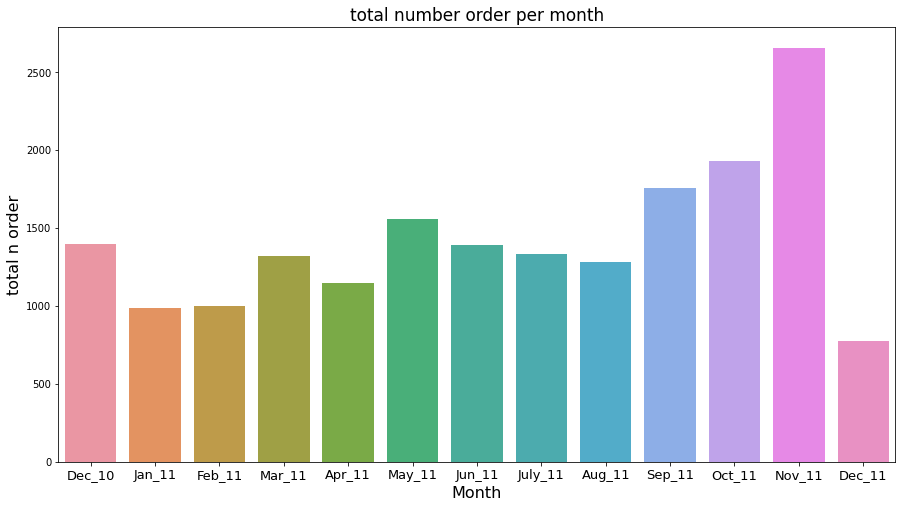

In [0]:
data_month = df_no_cancel.groupby('InvoiceNo')['yearmonth'].unique().value_counts().sort_index()

#create new dataframe
data_month = pd.DataFrame(data_month).reset_index()

#rename
data_month = data_month.rename(columns={'index':'yearmonth','yearmonth':'total order'})
data_month['yearmonth'] = data_month['yearmonth'].astype('str')

#plot the data
plt.figure(figsize=(15, 8))
ax = sns.barplot(x = "yearmonth",
                 y = "total order",
                 data=data_month)
plt.title("total number order per month", fontsize=17)
plt.xlabel("Month", fontsize=16)
plt.ylabel("total n order", fontsize=16)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11',
                    'Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11',
                    'Dec_11'), rotation='horizontal', fontsize=13)
plt.show()

Insight:
  1. November 2011 has the highest number of order, when the latest is december 2011

### how many orders per day

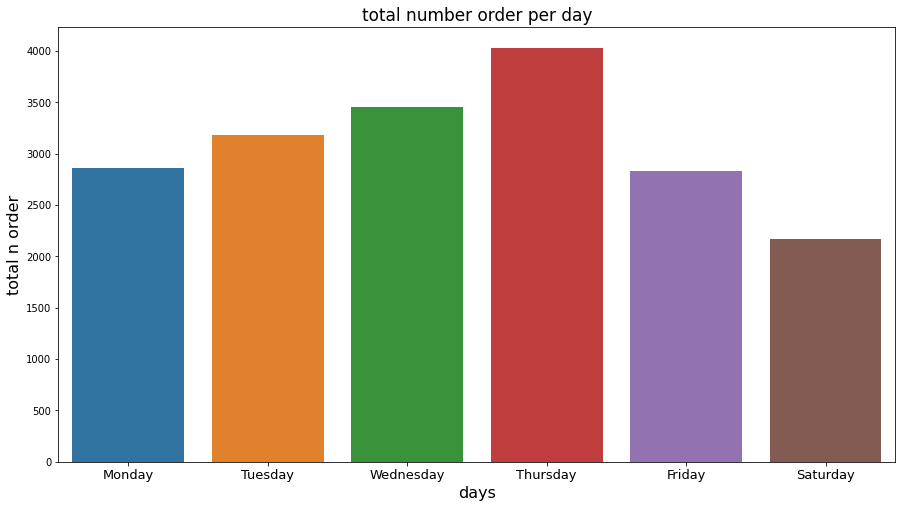

In [0]:
data_day = df_no_cancel.groupby('InvoiceNo')['days'].unique().value_counts().sort_index()

#create new dataframe
data_day = pd.DataFrame(data_day).reset_index()

#rename
data_day = data_day.rename(columns={'index':'day','days':'total order'})
data_day['day'] = data_day['day'].astype('str')

#plot the data
plt.figure(figsize=(15, 8))
ax = sns.barplot(x = "day",
                 y = "total order",
                 data=data_day)
plt.title("total number order per day", fontsize=17)
plt.xlabel("days", fontsize=16)
plt.ylabel("total n order", fontsize=16)
ax.set_xticklabels((('Monday','Tuesday','Wednesday',
                     'Thursday','Friday','Saturday')), rotation='horizontal', fontsize=13)
plt.show()

Insight:
  1. most of the customer order their items at thursday

### how many order per hours


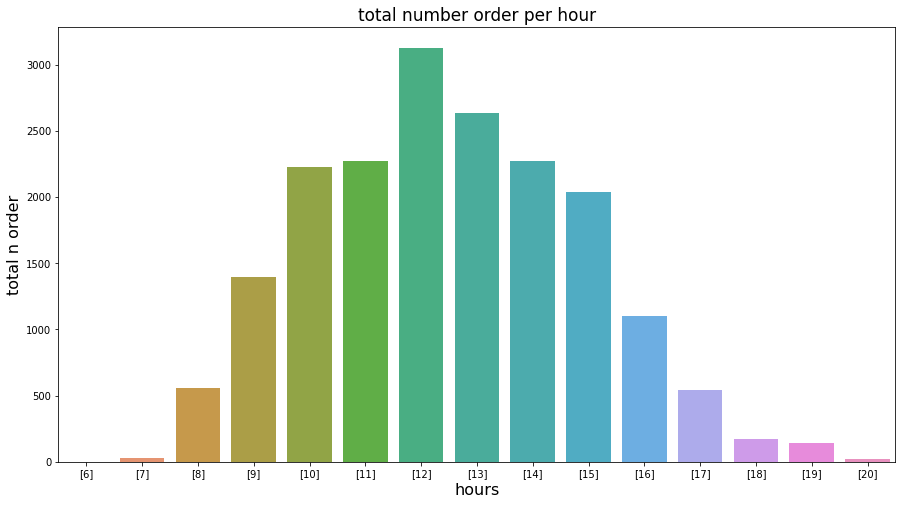

In [0]:

data_hour = df_no_cancel.groupby('InvoiceNo')['hour'].unique().value_counts().iloc[:-1].sort_index()

#create new dataframe
data_hour = pd.DataFrame(data_hour).reset_index()

#rename
data_hour = data_hour.rename(columns={'index':'hour','hour':'total order'})
data_hour['hour'] = data_hour['hour'].astype('str')

#plot the data
plt.figure(figsize=(15, 8))
ax = sns.barplot(x = "hour",
                 y = "total order",
                 data=data_hour)
plt.title("total number order per hour", fontsize=17)
plt.xlabel("hours", fontsize=16)
plt.ylabel("total n order", fontsize=16)
plt.show()

Insight:
  we could say that most of customer order their stuff between 12:00 and 13:00

### Favorite Items

In [0]:
## groupby description
df_d = new_df[['Description', 'InvoiceNo']]
df_d = df_d.groupby('Description')['InvoiceNo'].aggregate('count')

#create new dataframe
df_d = pd.DataFrame(df_d).reset_index()
df_d = df_d.rename(columns={'InvoiceNo':'total booking'})
df_d = df_d.sort_values('total booking', ascending=False)

df_d.head()

,Description,total booking
3698,WHITE HANGING HEART T-LIGHT HOLDER,2028
2767,REGENCY CAKESTAND 3 TIER,1724
1762,JUMBO BAG RED RETROSPOT,1618
216,ASSORTED COLOUR BIRD ORNAMENT,1408
2345,PARTY BUNTING,1397


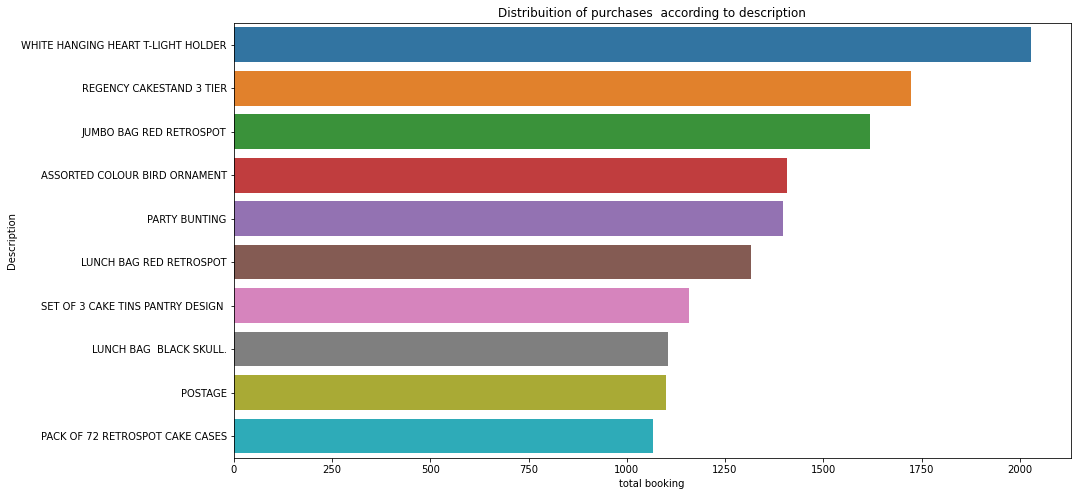

In [0]:
plt.figure(figsize=(15,8))
plt.title('Distribuition of purchases  according to description');
ax = sns.barplot(y = 'Description', x='total booking', data=df_c.head(10))
plt.show()

we can find that white hanging is the most favorute itrms in shop

# Customer Segmentation

Customer segmentation is the process of grouping your customers by common attributes or characteristics, which can be demographic or psychographic. The objective is to have a deeper understanding of each segment so you can market and message effectively.

source : https://medium.com/the-anatomy-of-marketing/how-to-know-your-customer-77f5f0349258


The most common ways in which businesses segment their customer base are:
1. Demographic information, such as gender, age, familial and marital status, income, education, and occupation.
2. Geographical information, which differs depending on the scope of the company. For localized businesses, this info might pertain to specific towns or counties. For larger companies, it might mean a customer’s city, state, or even country of residence.
3. Psychographics, such as social class, lifestyle, and personality traits.
4. Behavioral data, such as spending and consumption habits, product/service usage, and desired benefits.

## Geographic Segmentation (based on country)

In [0]:
## groupby country
df_c = new_df[['Country', 'CustomerID']]
df_c = df_c.groupby('Country')['CustomerID'].aggregate('count')

#create new dataframe
df_c = pd.DataFrame(df_c).reset_index()
df_c = df_c.rename(columns={'CustomerID':'Total customer'})
df_c = df_c.sort_values('Total customer', ascending=False)

df_c.head()


,Country,Total customer
35,United Kingdom,354345
14,Germany,9042
13,France,8342
10,EIRE,7238
30,Spain,2485


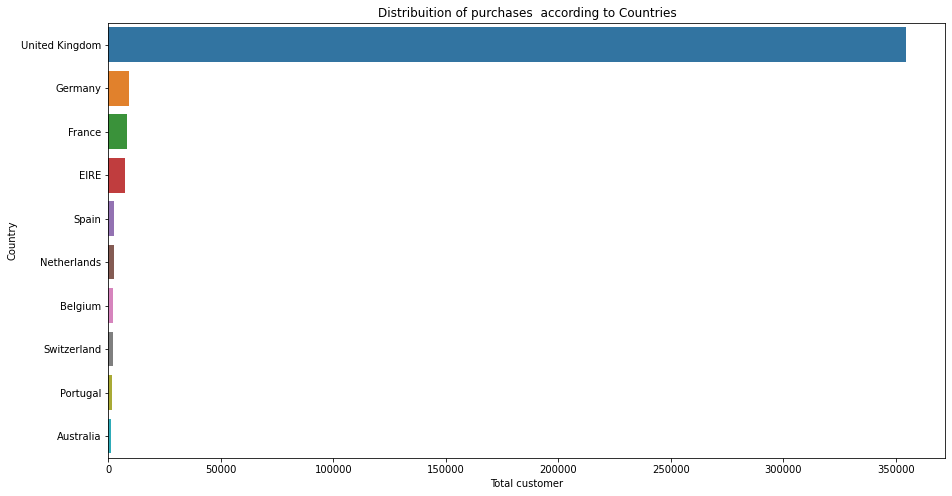

In [0]:
plt.figure(figsize=(15,8))
plt.title('Distribuition of purchases  according to Countries');
ax = sns.barplot(y = 'Country', x='Total customer', data=df_c.head(10))
plt.show()


we can found that, the retail has base country in the UK and only some percent came from others country, let's see data from other country except UK

In [0]:
not_uk = df[df['Country'] != 'United Kingdom']

## groupby country
df_country = not_uk[['Country', 'CustomerID']]
df_country = df_country.groupby('Country')['CustomerID'].aggregate('count')

#create new dataframe
df_country = pd.DataFrame(df_country)
df_country = df_country.rename(columns={'CustomerID':'Total customer'})
df_country = df_country.sort_values('Total customer', ascending=False).reset_index()

df_country.head()

,Country,Total customer
0,Germany,9495
1,France,8491
2,EIRE,7485
3,Spain,2533
4,Netherlands,2371


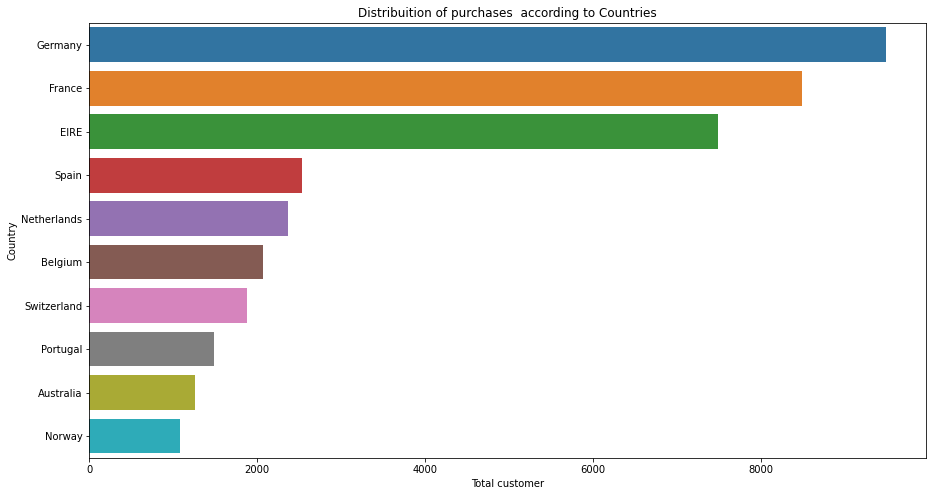

In [0]:
plt.figure(figsize=(15,8))
plt.title('Distribuition of purchases  according to Countries');
ax = sns.barplot(y = 'Country', x='Total customer', data=df_country.head(10))
plt.show()

We found that germany has the highest total customers, followed by France and EIRE, if we want to expant the retail bussiness, we cant start to country with the highest total customers

## Behavioral segmentation

since the data only have information about sales record and not contain any insight or information about the customers, i will choose RFM analysis for behavioral customers segmentation

according to [datacamp]('https://www.datacamp.com/community/tutorials/introduction-customer-segmentation-python'), RFM (Recency, Frequency, Monetary) analysis is a behavior-based approach grouping customers into segments. It groups the customers on the basis of their previous purchase transactions. How recently, how often, and how much did a customer buy. RFM filters customers into various groups for the purpose of better service. It helps managers to identify potential customers to do more profitable business.

The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:

*   Recency: The value of how recently a customer purchased at the establishment
*   Frequency: How frequent the customer’s transactions are at the establishment
*   Monetary value: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment


### Prepare the data

In [0]:
#check the data

new_df.describe()

,Quantity,UnitPrice,CustomerID,total price,is_canceled,year,yearmonth,month,days,hour
count,397924.000000,397924.000000,397924.000000,397924.000000,397924.0,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171,22.394749,0.0,2010.934259,201101.038417,7.612537,3.614555,12.728247
std,180.420210,22.096788,1713.169877,309.055588,0.0,0.247829,23.836517,3.416527,1.928274,2.273535
min,1.000000,0.000000,12346.000000,0.000000,0.0,2010.000000,201012.000000,1.000000,1.000000,6.000000
25%,2.000000,1.250000,13969.000000,4.680000,0.0,2011.000000,201104.000000,5.000000,2.000000,11.000000
50%,6.000000,1.950000,15159.000000,11.800000,0.0,2011.000000,201107.000000,8.000000,3.000000,13.000000
75%,12.000000,3.750000,16795.000000,19.800000,0.0,2011.000000,201110.000000,11.000000,5.000000,14.000000
max,80995.000000,8142.750000,18287.000000,168469.600000,0.0,2011.000000,201112.000000,12.000000,7.000000,20.000000


There was no negative value inside the data, so we can continue to analysis

### Recency

In [0]:
reference_date = new_df.InvoiceDate.max() + datetime.timedelta(days = 1)
last_shop = (reference_date - new_df.InvoiceDate).dt.days
last_shop = pd.DataFrame(new_df.CustomerID).merge(pd.DataFrame(last_shop),left_index=True, right_index=True)
last_shop = last_shop.rename(columns={'InvoiceDate': 'Recency'})

recency = pd.DataFrame(last_shop.groupby('CustomerID')['Recency'].min()).reset_index()
recency

,CustomerID,Recency
0,12346.0,326
1,12347.0,2
2,12348.0,75
3,12349.0,19
4,12350.0,310
...,...,...
4334,18280.0,278
4335,18281.0,181
4336,18282.0,8
4337,18283.0,4


### Frequency 

In [0]:
n_shopping = df_no_cancel.groupby(['CustomerID'])['InvoiceNo'].aggregate('count').reset_index()
frequency = n_shopping.rename(columns={'InvoiceNo': 'Frequency'})
frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


### Monetary (total shopping)

In [0]:
total_shopping = df_no_cancel.groupby(['CustomerID'])['total price'].aggregate('sum').reset_index()
monetary = total_shopping.rename(columns={'total price':'Monetary'})
monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### RFM Dataframe

In [0]:
df_rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')

df_rfm.head(10)

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40
5,12352.0,36,85,2506.04
6,12353.0,204,4,89.00
7,12354.0,232,58,1079.40
8,12355.0,214,13,459.40
9,12356.0,23,59,2811.43


## Clustering for behavioral segmentation

### Data Preprocessing

the data has skew value 1.2463568823921842 and kurtosis 0.4313819841908968


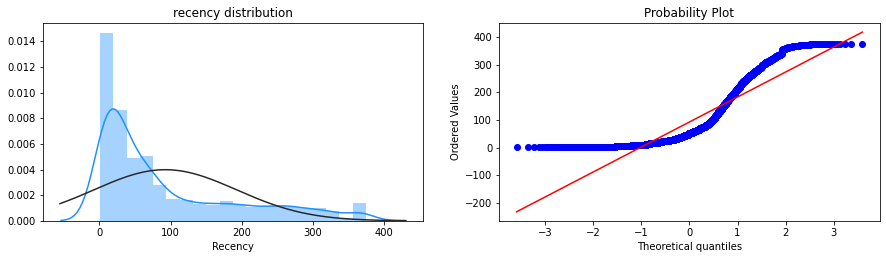

In [0]:
# Recency
#check skewness
r_skew = df_rfm['Recency'].skew()
r_kurs = df_rfm['Recency'].kurt()
print('the data has skew value {} and kurtosis {}'.format(r_skew, r_kurs))

plt.figure(figsize=(15,8))
plt.subplot(221)
sns.distplot(df_rfm['Recency'],fit=norm,color="dodgerblue",bins=20)
plt.title('recency distribution')


#QQ plot
plt.subplot(222)
stats.probplot(df_rfm['Recency'], plot=plt)
plt.show()

from the graph above, we could say that recency columns has far from normal distribution,

with skewness 1.24 and probability plot that not align with red lines indicate that the data is right skewness

also, we found that data has kurtosis value 0.43, which is mean that data is heavy-tailed distribution and has some outliers

the data has skew value 18.106242903118684 and kurtosis 483.4172030941453


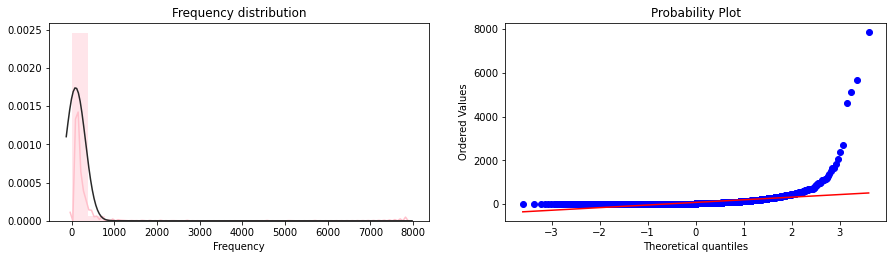

In [0]:
# Frequency
#check skewness
f_skew = df_rfm['Frequency'].skew()
f_kurs = df_rfm['Frequency'].kurt()
print('the data has skew value {} and kurtosis {}'.format(f_skew, f_kurs))

plt.figure(figsize=(15,8))
plt.subplot(221)
sns.distplot(df_rfm['Frequency'],fit=norm,color="pink",bins=20)
plt.title('Frequency distribution')


#QQ plot
plt.subplot(222)
stats.probplot(df_rfm['Frequency'], plot=plt)
plt.show()

the line graph above depicts that data is extremely biased and not normally distributed.

with skewness = 18 and kurtosis 483 we can conclude that the data is extemely positive skewed, heavy-tailed distribution with many outliers inside the data

the data has skew value 19.326985305561827 and kurtosis 478.1513776539141


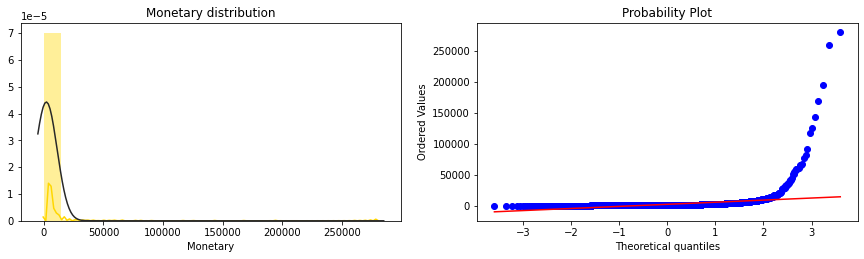

In [0]:
# monetary
#check skewness
m_skew = df_rfm['Monetary'].skew()
m_kurs = df_rfm['Monetary'].kurt()
print('the data has skew value {} and kurtosis {}'.format(m_skew, m_kurs))

plt.figure(figsize=(15,8))
plt.subplot(221)
sns.distplot(df_rfm['Monetary'],fit=norm,color="gold",bins=20)
plt.title('Monetary distribution')


#QQ plot
plt.subplot(222)
stats.probplot(df_rfm['Monetary'], plot=plt)
plt.show()

same as frequency columns, the data was extremely right skeewed, hevy-tailed distribution with many outliers

#### deal with not-normal distribution dataset

right skeweed and heavy-tailed distribution can make our clustering machine  create bias in the process of  clustering segmentation, to solve the problem, i will log transform 3 columns above after that rescale using scaler to make every data in all columns has same range. 

In [0]:
norm_df_rfm = df_rfm.copy()
norm_df_rfm = norm_df_rfm.drop('CustomerID',axis=1)

In [0]:

power = PowerTransformer().fit(norm_df_rfm)
rfm_scaled =power.transform(norm_df_rfm)

#Standard Scaler to Scale the data
scaler = StandardScaler().fit(rfm_scaled)
rfm_scaled = scaler.transform(rfm_scaled)

#### check the data

the data has skew value -0.05647257062038645 and kurtosis -0.9134720519074602


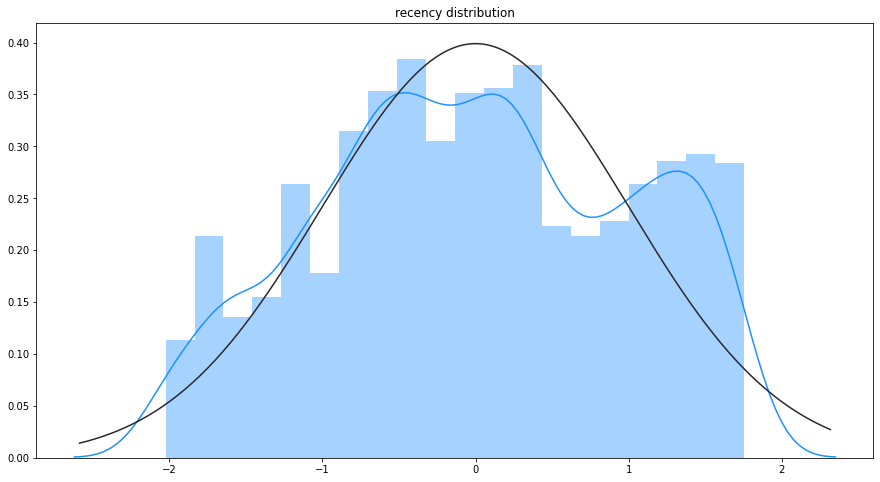

In [0]:
#recency
new_r_skew = skew(rfm_scaled)[0]
new_r_kurs = kurtosis(rfm_scaled)[0]
print('the data has skew value {} and kurtosis {}'.format(new_r_skew, new_r_kurs))

plt.figure(figsize=(15,8))
sns.distplot(rfm_scaled[:,0],fit=norm,color="dodgerblue",bins=20)
plt.title('recency distribution')
plt.show()

the data has skew value -0.00010273449187216635 and kurtosis -0.0573146321617668


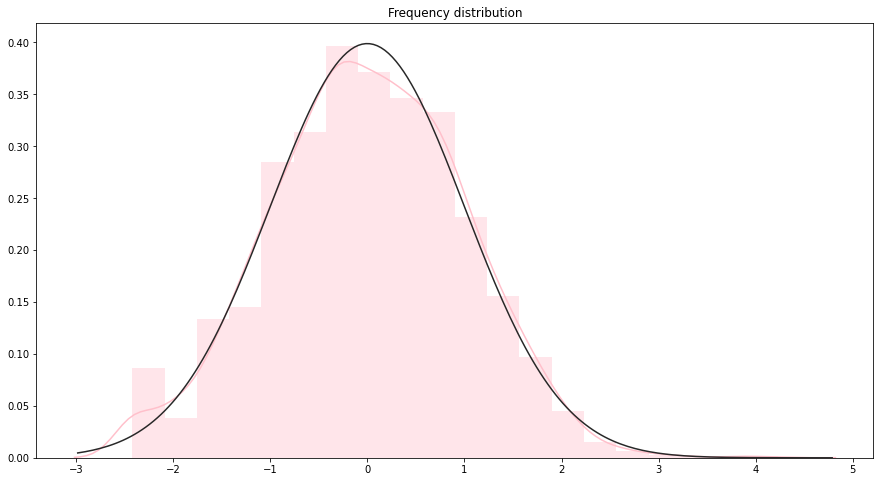

In [0]:
# Frequency
#check skewness
new_f_skew = skew(rfm_scaled)[1]
new_f_kurs = kurtosis(rfm_scaled)[1]
print('the data has skew value {} and kurtosis {}'.format(new_f_skew, new_f_kurs))

plt.figure(figsize=(15,8))
sns.distplot(rfm_scaled[:,1],fit=norm,color="pink",bins=20)
plt.title('Frequency distribution')
plt.show()

the data has skew value -0.022745470391299323 and kurtosis 0.831409083153781


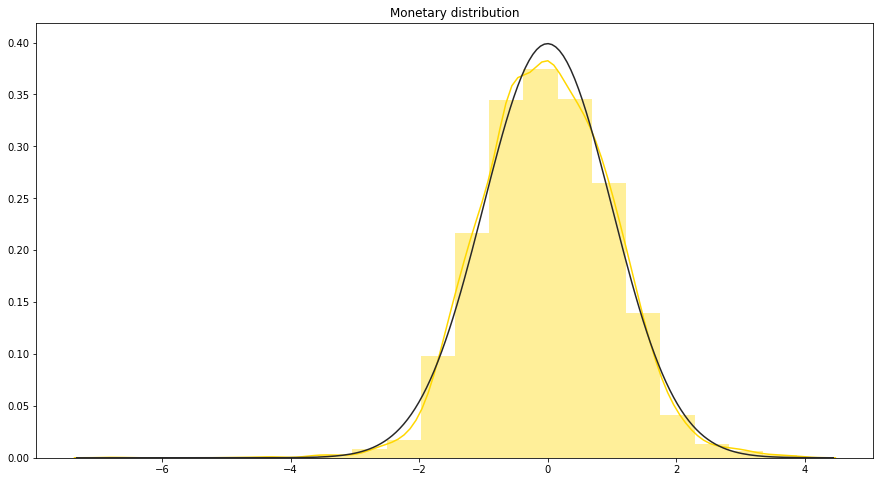

In [0]:
# monetary
#check skewness
new_m_skew = skew(rfm_scaled)[2]
new_m_kurs = kurtosis(rfm_scaled)[2]
print('the data has skew value {} and kurtosis {}'.format(new_m_skew, new_m_kurs))

plt.figure(figsize=(15,8))
sns.distplot(rfm_scaled[:,2],fit=norm,color="gold",bins=20)
plt.title('Monetary distribution')
plt.show()

even recency have slight skewness, we can conclude that all the data are normally distributed

### K-Means Clustering

#### elbow method

for the first, i will use elbow method in distorsion and inertia to find the optimal number of clusters. The idea behind the elbow method is to identify the value of k where the distortion or inertia begins to increase most rapidly. If k increases, the distortion or inertia will decrease, because the samples will be closer to the centroids they are assigned to. 

1. Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.

2. Inertia: It is the sum of squared distances of samples to their closest cluster center.

In [0]:
distorsion = []
inertia = []
map_1 = {}
map_2 ={}
cl = 10

for i in range(1,cl+1):
  models = KMeans(n_clusters=i,init='k-means++',max_iter=300, n_init=10, random_state=0)
  models.fit(rfm_scaled)
  distorsion.append(sum(np.min(cdist(rfm_scaled, models.cluster_centers_, 
                      'euclidean'),axis=1)) / rfm_scaled.shape[0])
  inertia.append(models.inertia_)
  map_1[i] = sum(np.min(cdist(rfm_scaled, models.cluster_centers_, 
                 'euclidean'),axis=1)) / rfm_scaled.shape[0] 
  map_2[i] = models.inertia_ 



visualize the results

cluster 1 has distorsion value 1.5517857759311422
cluster 2 has distorsion value 1.133004189281925
cluster 3 has distorsion value 0.9887271961048563
cluster 4 has distorsion value 0.8937004732509164
cluster 5 has distorsion value 0.8299302836332505
cluster 6 has distorsion value 0.7738894248235805
cluster 7 has distorsion value 0.7335710128104692
cluster 8 has distorsion value 0.703630013005807
cluster 9 has distorsion value 0.6893702062501429
cluster 10 has distorsion value 0.6566771526881907




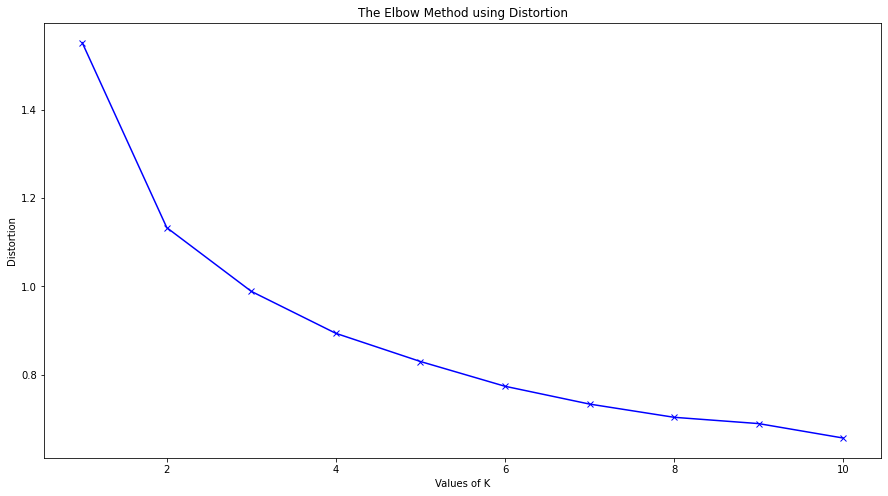

In [0]:
#distorsion
for key,value in map_1.items():
  print('cluster {} has distorsion value {}'.format(key,value))

print('\n')
plt.figure(figsize=(15,8))
plt.plot(range(1,11), distorsion, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 


cluster 1 has inertia value 13017.000000000002
cluster 2 has inertia value 6754.9749110835955
cluster 3 has inertia value 5236.309434668392
cluster 4 has inertia value 4287.7345066338685
cluster 5 has inertia value 3689.166826374757
cluster 6 has inertia value 3224.9872984699014
cluster 7 has inertia value 2939.761075021346
cluster 8 has inertia value 2721.8103287150543
cluster 9 has inertia value 2546.5322040256865
cluster 10 has inertia value 2388.889421519455




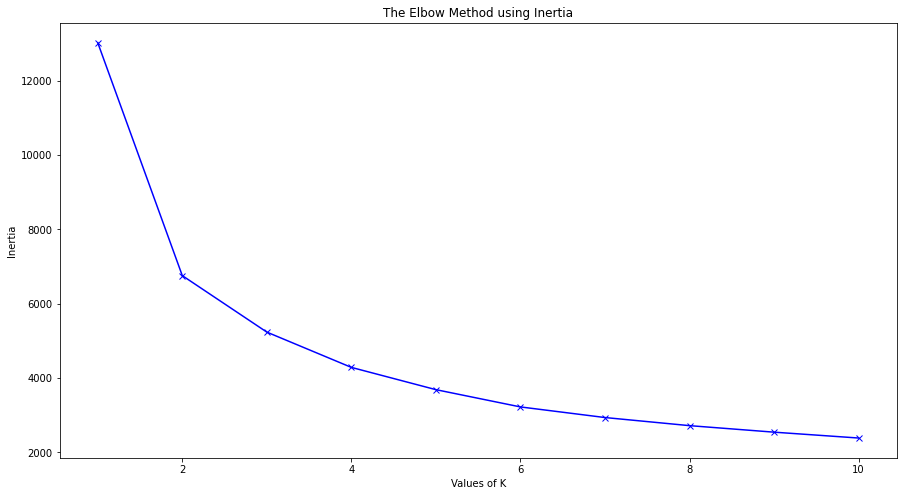

In [0]:
#inertia
for key,value in map_2.items():
  print('cluster {} has inertia value {}'.format(key,value))

print('\n')
plt.figure(figsize=(15,8))
plt.plot(range(1,11), inertia, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

using both analysis above, we can conclude that the highest change was happen between 4,5 and 6 cluster.

#### Shihoutte Analysis

after got the list of best cluster, i will use shihoutte analysis to find cluster with the best shihoutte value

Silhouette analysis on K-Means clustering
Silhouette analysis can be used to study the separation distance between the resulting clusters, as a strategy to quantifying the quality of clustering via graphical tool to plot a measure of how tightly grouped the samples in the clusters are. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.

source : https://www.kaggle.com/mgmarques/customer-segmentation-and-market-basket-analysis

For n_clusters = 2 The average silhouette_score is : 0.396689892885645


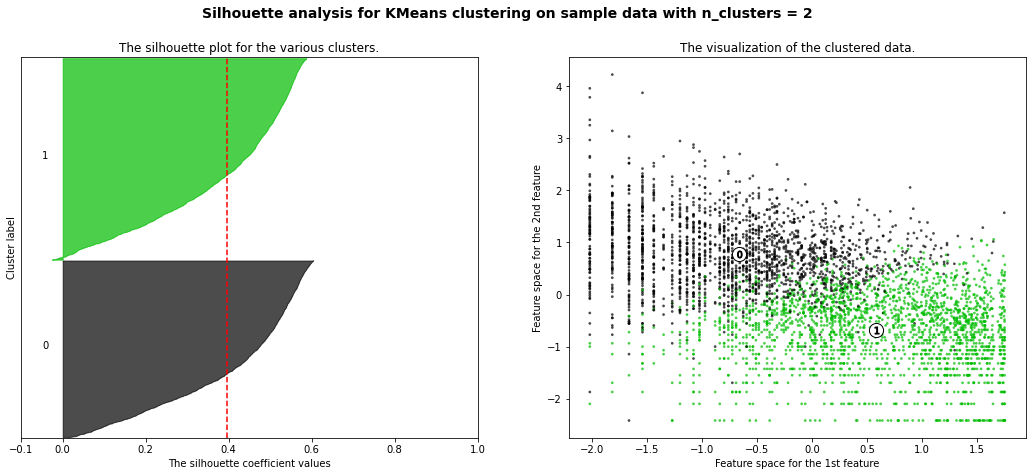

For n_clusters = 3 The average silhouette_score is : 0.29952912686846084


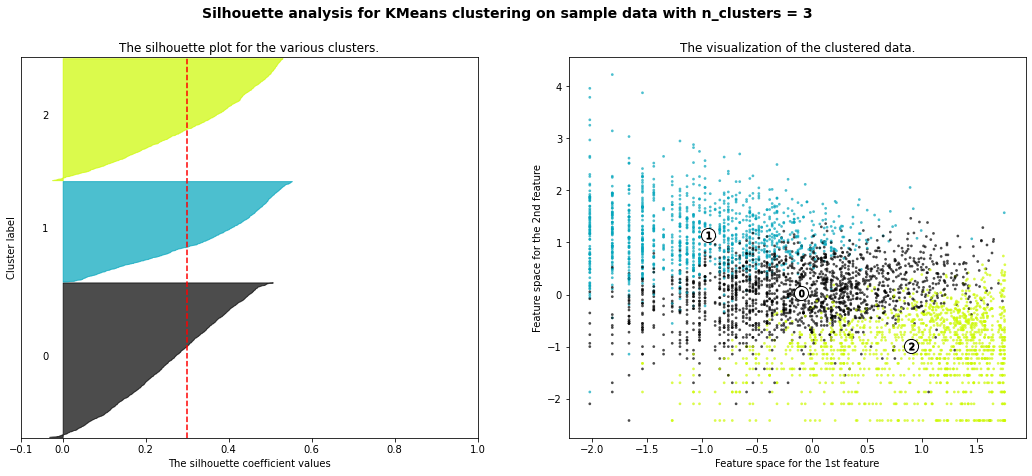

For n_clusters = 4 The average silhouette_score is : 0.3044718924350109


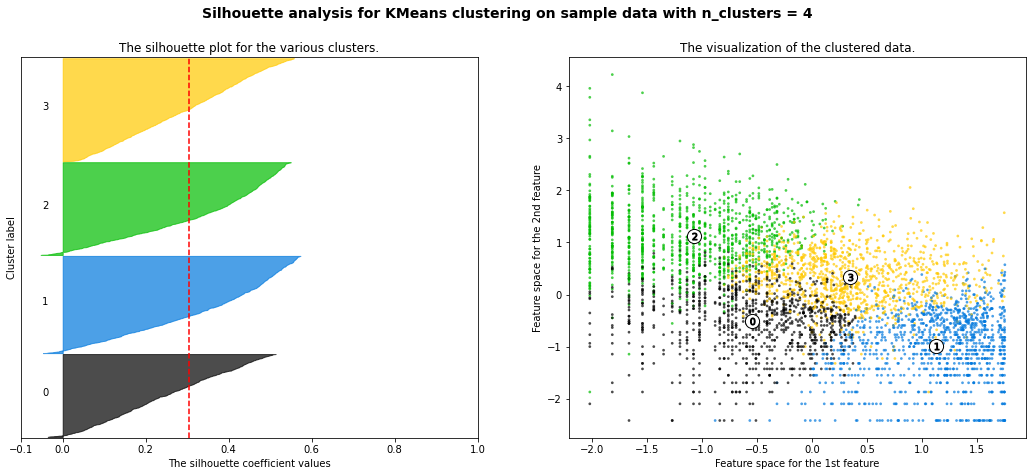

For n_clusters = 5 The average silhouette_score is : 0.27731263762955316


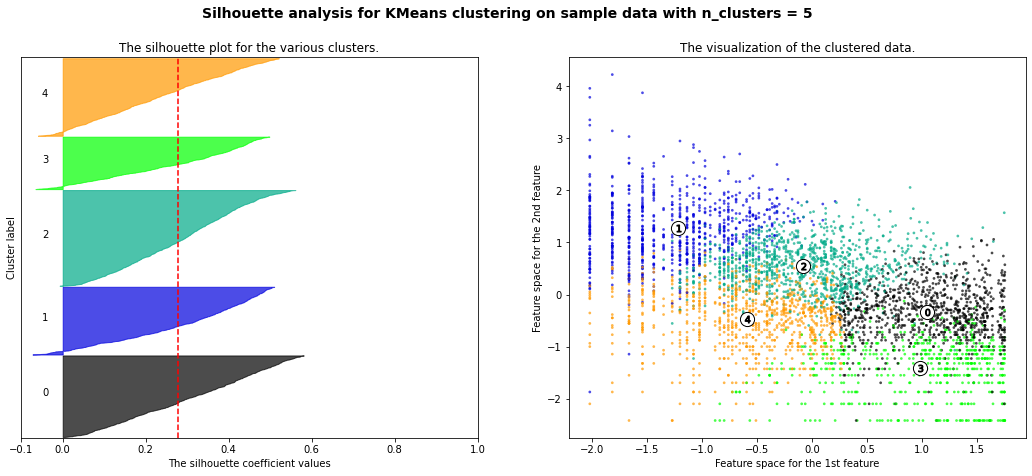

For n_clusters = 6 The average silhouette_score is : 0.277072376550618


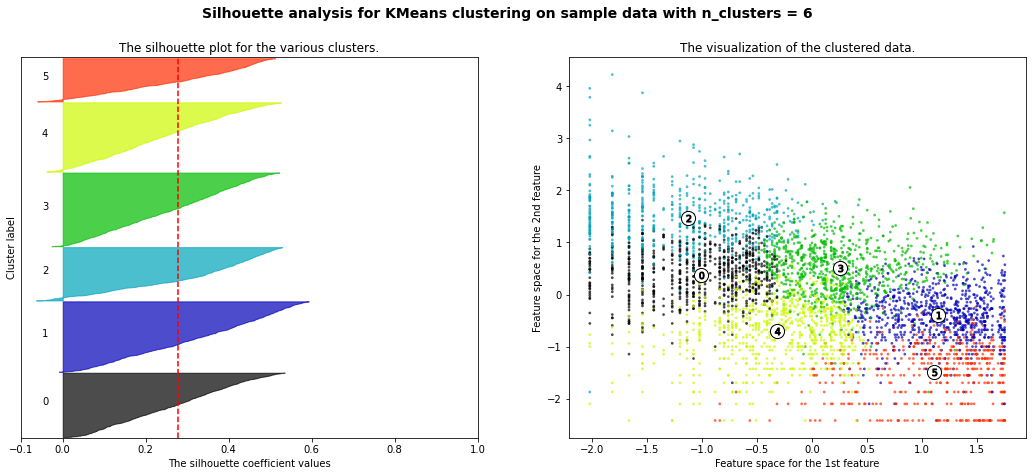

In [0]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(rfm_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,init='k-means++',max_iter=300, n_init=10, random_state=0)
    cluster_labels = clusterer.fit_predict(rfm_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(rfm_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(rfm_scaled[:, 0], rfm_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

Insight:
  1. Interestingly, all the cluster are valid, because because they don't have presence of clusters with below average silhouette scores.
  2. we got two candidate of the best cluster , which is 2 and 4, both have shihoutte score 0.37 and 0.30, but i will prefer cluster4 because in the elbow method, cluster 4 is the place when the lineplot start to change.

In [0]:
n = 4

model = KMeans(n_clusters=n,init='k-means++',max_iter=300, n_init=10, random_state=0)

#fit the data
model_kmeans = model.fit(rfm_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model_kmeans.labels_

centers = model_kmeans.cluster_centers_

In [0]:
centers

array([[-0.55101225, -0.50760198, -0.55016062],
       [ 1.13164323, -0.99281337, -0.95857753],
       [-1.07111949,  1.12984734,  1.11019015],
       [ 0.34379847,  0.3273275 ,  0.34713194]])

### analysis the clusters

In [0]:
#Append labels/clusters to scaled and original dataframe
df_rfm['cluster'] = labels
clusters_seg = pd.DataFrame(rfm_scaled,columns=['recency','frequency','monetary'])
clusters_seg['Cluster'] = labels+1

In [0]:
clusters = []

for i in range(0,n):
    clusters.append(df_rfm[df_rfm.cluster==i])

values = power.inverse_transform(scaler.inverse_transform(centers))

for i in range(0,n):
    print('-----CLUSTER {}-----'.format(i+1))
    print('Number of Customers: {}'.format(clusters[i].shape[0]))
    print('total purchases: £{:6.2f}'.format(values[i][2]))
    print('Purchases Frequency : {:4.0f}'.format(values[i][1]))
    print('Last Day Shopping: {:4.0f}\n'.format(values[i][0]))

-----CLUSTER 1-----
Number of Customers: 957
total purchases: £351.52
Purchases Frequency :   21
Last Day Shopping:   24

-----CLUSTER 2-----
Number of Customers: 1122
total purchases: £218.21
Purchases Frequency :   11
Last Day Shopping:  197

-----CLUSTER 3-----
Number of Customers: 1071
total purchases: £2957.32
Purchases Frequency :  171
Last Day Shopping:   10

-----CLUSTER 4-----
Number of Customers: 1189
total purchases: £1065.84
Purchases Frequency :   62
Last Day Shopping:   79



Analysis:
1. Cluster 3  is **gold cluster** with the highest total purchases, purchases Frequency and the smallest Last day shopping, we can concluede that people in champions cluster is regular customers of the shop and we need give them reward such as discount.
2. Cluster 4 is **silver cluster** with second highest total purchases and frequency. we also find that the cluster has wide-range last day shopping (79). It's look like customers in the cluster 4 only sometimes buy items from shop, but went they buy items, the customer always buy with high frequency or buy expensive items. for this cluster, we can give them discount and recomendation items (depends on their purchase history) to make range 'last day shopping' became smaller.
3. cluster 1 is **bronze cluster** because they has smaller total purchases and frequency than cluster 4, but has smaller 'last day shopping' than cluster 4, we can conclude that the customers in cluster 3 are regular customers but always buy cheapest items or only buy some items. we can give them recomendation items (items with more better quality) to make the customers want to spend more money.
4. cluster 2 is **high risk cluster** because they has smallest total purchases and frequency, also highest 'last day shopping' among all clusters. we need different strategy for this cluster, such as give them events and more discount(like discount 60%) if they buy same items

# Market Basket Analysis

![alt text](https://miro.medium.com/max/1400/1*DHfQvlMVBaJCHpYmj1kmCw.png)

**Market basket analysis** is a data mining technique used by retailers to increase sales by better understanding customer purchasing patterns. It involves analyzing large data sets, such as purchase history, to reveal product groupings, as well as products that are likely to be purchased together.

### **Algorithms associated with market basket analysis**
In market basket analysis, association rules are used to predict the likelihood of products being purchased together. Association rules count the frequency of items that occur together, seeking to find associations that occur far more often than expected.

Algorithms that use association rules include AIS, SETM and **Apriori**. **The Apriori algorithm** is commonly cited by data scientists in research articles about market basket analysis and is used to identify frequent items in the database, then evaluate their frequency as the datasets are expanded to larger sizes.

### **Apriori Algorithm**
Apriori algorithm assumes that any subset of a frequent itemset must be frequent. Its the algorithm behind Market Basket Analysis.

Say, a transaction containing {Grapes, Apple, Mango} also contains {Grapes, Mango}. So, according to the principle of Apriori, if {Grapes, Apple, Mango} is frequent, then {Grapes, Mango} must also be frequent.
Here is a dataset consisting of six transactions. Each transaction is a combination of 0s and 1s, where 0 represents the absence of an item and 1 represents the presence of it.
![alt text](https://miro.medium.com/max/1232/1*E9tVy9Y2Fe2T-ObXxpHwmA.png)


In order to find out interesting rules out of multiple possible rules from this small business scenario, we will be using the following matrices:
1. **Support**: Its the default popularity of an item. In mathematical terms, the support of item A is nothing but the ratio of transactions involving A to the total number of transactions.
  1. Support(Grapes) = (Transactions involving Grapes)/(Total transaction), example : Support(Grapes) = 0.666
2. **Confidence**: Likelihood that customer who bought both A and B. Its divides the number of transactions involving both A and B by the number of transactions involving B.
  1. Confidence(A => B) = (Transactions involving both A and B)/(Transactions involving only A). example: Confidence({Grapes, Apple} => {Mango}) = Support(Grapes, Apple, Mango)/Support(Grapes, Apple)
= 2/6 / 3/6
= 0.667
3. **Lift** : Increase in the sale of A when you sell B.
Lift(A => B) = Confidence(A, B) / Support(B)
Lift ({Grapes, Apple} => {Mango}) = 1
So, likelihood of a customer buying both A and B together is ‘lift-value’ times more than the chance if purchasing alone.
  1. Lift (A => B) = 1 means that there is no correlation within the itemset.
  2. Lift (A => B) > 1 means that there is a positive correlation within the itemset, i.e., products in the itemset, A, and B, are more likely to be bought together.
  3. Lift (A => B) < 1 means that there is a negative correlation within the itemset, i.e., products in itemset, A, and B, are unlikely to be bought together.




source : https://towardsdatascience.com/market-basket-analysis-978ac064d8c6

In [0]:
# Dummy conding and creation of the baskets_sets, 
#indexed by InvoiceNo with 1 corresponding to every item presented on the basket

basket = new_df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)

def is_one(data):
  if data <= 0 :
    return 0
  else:
    return 1
basket = basket.applymap(is_one)

basket.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,...,YELLOW DRAGONFLY HELICOPTER,YELLOW EASTER EGG HUNT START POST,YELLOW FELT HANGING HEART W FLOWER,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Apriori aplication: frequent_itemsets
frequent_item = ap(basket, min_support=0.01, use_colnames=True)
frequent_item['length'] = frequent_item['itemsets'].apply(lambda x: len(x))

# Advanced and strategical data frequent set selection
frequent_item.head()

,support,itemsets,length
0,0.010358,( SET 2 TEA TOWELS I LOVE LONDON ),1
1,0.013056,(10 COLOUR SPACEBOY PEN),1
2,0.010088,(12 MESSAGE CARDS WITH ENVELOPES),1
3,0.014890,(12 PENCIL SMALL TUBE WOODLAND),1
4,0.016562,(12 PENCILS SMALL TUBE RED RETROSPOT),1


In [0]:
# Generating the association_rules: rules
# Selecting the important parameters for analysis
rules = association_rules(frequent_item, metric="lift", min_threshold=1)
rules.sort_values('support', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
225,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.086319,0.046990,0.029456,0.341250,7.262239,0.025400,1.446695
224,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.046990,0.086319,0.029456,0.626866,7.262239,0.025400,2.448666
118,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.037279,0.042242,0.029186,0.782923,18.534184,0.027612,4.412071
119,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.042242,0.037279,0.029186,0.690932,18.534184,0.027612,3.114920
26,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.042566,0.047313,0.028593,0.671736,14.197612,0.026579,2.902200
27,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.047313,0.042566,0.028593,0.604333,14.197612,0.026579,2.419798
406,(LUNCH BAG RED RETROSPOT),(LUNCH BAG PINK POLKADOT),0.069486,0.050227,0.028215,0.406056,8.084481,0.024725,1.599096
407,(LUNCH BAG PINK POLKADOT),(LUNCH BAG RED RETROSPOT),0.050227,0.069486,0.028215,0.561762,8.084481,0.024725,2.123304
333,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.056754,0.069486,0.027892,0.491445,7.072533,0.023948,1.829720
332,(LUNCH BAG RED RETROSPOT),(LUNCH BAG BLACK SKULL.),0.069486,0.056754,0.027892,0.401398,7.072533,0.023948,1.575746


we can conclude  jumbo bag has highest confidence, and most of antecendents and consequents came from same items but with differents colour,

for the first strategy we need give a lot of attention to the combination of items with different color

# Conclusion

1. Most of customers came from UK, which is mean that the shop have base in UK.
2. There was a potential customers in Germany, France and AIRE. with good strategy, we can gain more customers from that,
3. From the customers segmentation based on RFM analysis, we got 4 clusters with different customers behavior.
4. most potential cluster is came from cluster 3, when customers from cluster 3, has the highest frequency and monetary, also smallest recency, with good strategy we can retain the customers
5. according to Market basket analysis, combine same items with different colour is the right strategy among all items.